In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pymongo import MongoClient

In [4]:
mongo_uri = "mongodb://hadoop-vm.internal.cloudapp.net:27017/ca2"

client = MongoClient(mongo_uri)
db = client["ca2"]
collection = db["vaccin_tweets_2_202004"]
collection_sentiment = db["vaccin_tweets_2_202004_sentiment"]

# Convert MongoDB collection to pandas DataFrame
data = pd.DataFrame(list(collection.find()))
data_sentiment = pd.DataFrame(list(collection_sentiment.find()))


In [5]:
data.head()

,_id,coordinates,text,timestamp,timestamp_ms
0,1255385449109037058,None,COVID-ALERT: Pfizer coronavirus vaccine could ...,2020-04-29 06:36:29.658,1588142189658
1,1255387944732557315,None,"Dr David Eedes, clinical oncology advisor of I...",2020-04-29 06:46:24.661,1588142784661
2,1255388825532203009,None,@elonmusk @RationalEtienne 👏👏👏 maintain medica...,2020-04-29 06:49:54.660,1588142994660
3,1255390373234556929,None,THE CORONAVIRUS VACCINE: Should You Get The Co...,2020-04-29 06:56:03.661,1588143363661
4,1255391195313954820,None,RT @KTHopkins: A mandatory #COVID19 vaccine. \...,2020-04-29 06:59:19.660,1588143559660


In [6]:
data_sentiment.head()

,_id,sentiment,s_probability
0,1255385449109037058,neutral,0.812073
1,1255387944732557315,neutral,0.909928
2,1255388825532203009,neutral,0.451752
3,1255390373234556929,neutral,0.948563
4,1255391195313954820,neutral,0.841724


In [7]:
# Inner join
data = pd.merge(data, data_sentiment, on='_id', how='inner')

In [8]:
# Add Date column and create index
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['date'] = data['timestamp'].dt.date

# Add Is Retweet column
data['is_retweet'] = data['text'].apply(lambda x: 1 if 'RT' in x else 0)

# Calculate avg_sentiment_score
df_grouped = data.groupby('date').agg(avg_sentiment_score=('s_probability', 'mean'))
df_grouped['retweet_rate'] = data.groupby('date')['is_retweet'].mean()

In [9]:
df_grouped.head()

,avg_sentiment_score,retweet_rate
date,,
2020-01-01,0.744125,0.333333
2020-01-02,0.751631,0.666667
2020-01-03,0.653364,0.454545
2020-01-04,0.759049,0.551724
2020-01-05,0.748756,0.661017


# Check stationationary

In [ ]:
# Check for stationarity with Dickey-Fuller test
result = adfuller(df_grouped['avg_sentiment_score'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])



> Data is stationary 

In [15]:
startdate = pd.to_datetime("2020-04-01").date()
split_date = pd.to_datetime("2021-02-01").date()
enddate = pd.to_datetime("2021-05-01").date()

In [36]:
# Prepare train and test datasets
train = df_grouped.loc[startdate:split_date]['avg_sentiment_score']
test = df_grouped.loc[split_date:enddate]['avg_sentiment_score']

In [38]:
train.count(), test.count()

(284, 60)

# Autocorrelation

C:\Users\rmsry\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


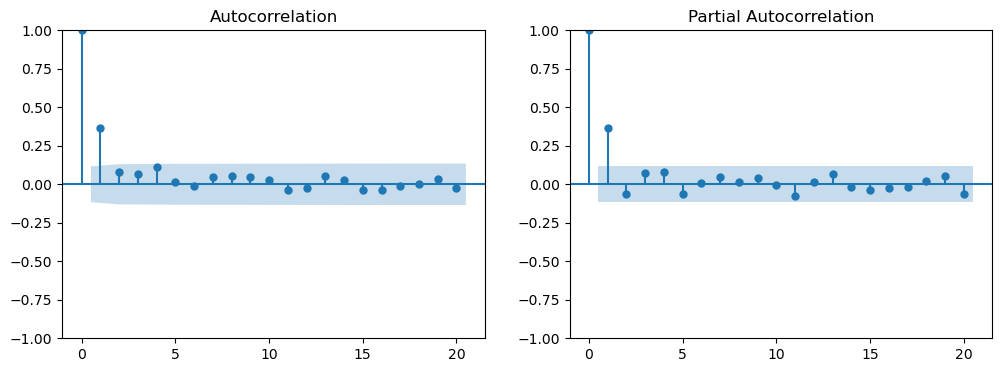

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train.values, lags=20, ax=ax1)
plot_pacf(train.values, lags=20, ax=ax2)
plt.show()

# SARIMA

In [86]:
p = 1
d = 0
q = 1
s = 28  # Seasonal period 7 days
P = 1
D = 1
Q = 1

model = SARIMAX(train.values, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

In [87]:
predictions = results.get_forecast(steps=len(test.values))

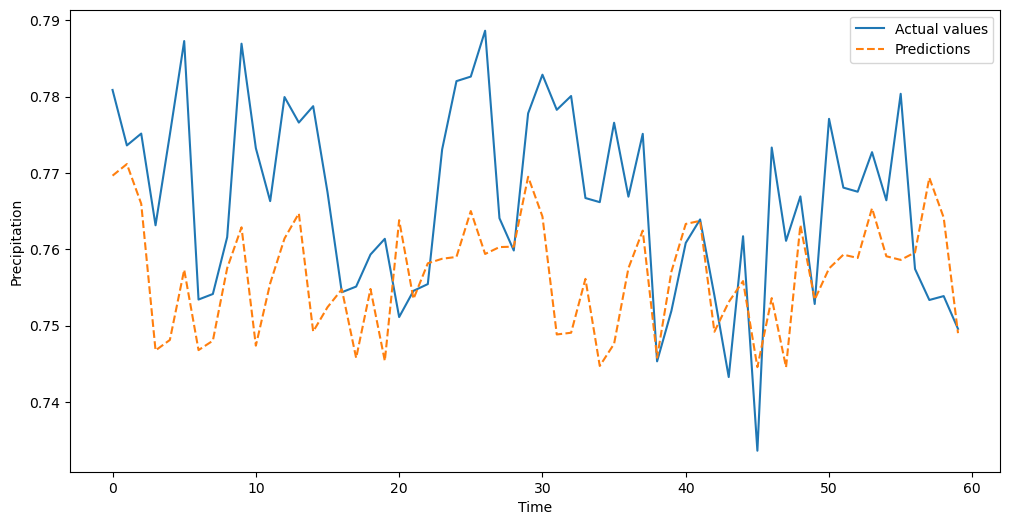

In [88]:
plt.figure(figsize=(12, 6))
#plt.plot(train_data, label='Training Data')
plt.plot(test.values, label='Actual values')
plt.plot(predictions.predicted_mean, label='Predictions', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.legend()
plt.show()

# Autoarima

In [75]:
#%pip install pmdarima

     -------------------------------------- 572.7/572.7 kB 7.1 MB/s eta 0:00:00
     ---------------------------------------- 9.4/9.4 MB 7.4 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.0
    Uninstalling statsmodels-0.13.0:
      Successfully uninstalled statsmodels-0.13.0
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\rmsry\\AppData\\Roaming\\Python\\Python39\\site-packages\\~tatsmodels\\tsa\\innovations\\_arma_innovations.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [76]:
import pmdarima as pm

ModuleNotFoundError: No module named 'pmdarima'